# **LAB: CROSS-VALIDATION AND THE BOOTSTRAP**
Packages used:
 - `statsmodels` is meant for "conducting statistical tests, and statistical data exploration" it is technically more similar to R in its function, syntax and general use;
 - `sklearn` is meant for prediction; knowledge of scikit-learn is a very valuable skill nowadays, so I thought it best to include it;
 - and of course, `pandas` for data wrangling and organizing, as well as `matplotlib` and `seaborn` for pictures.


In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from scipy import stats


sns.set_theme(style="darkgrid")

---
## **1. The Validation Set approach**

We'll use the `Auto` dataset which is part of the `ISLR` package and available as a .csv in the data folder.

In [15]:
auto = pd.read_csv('data/Auto.csv')
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


Optional: we are going to predict `mpg` as a function of `horsepower`. Here's the graph:

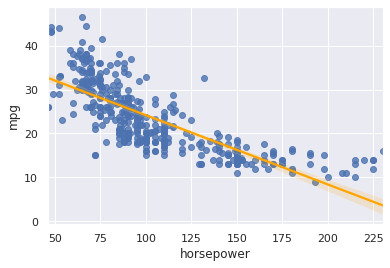

In [84]:
sns.regplot(x='horsepower', y='mpg', data=auto, line_kws={'color':'orange'});

We split the dataset into a training and a testing subsets using `sklearn`'s `train_test_split` function; the parameter `train_size` can be an integer (number of observations) or a number between 0 and 1 (fraction of observations in the training set). By default, the testing set is the complement of the training set, but it can be set to be smaller than that with `test_size`. 

*Note:* We also fix a `random_state` for reproducibility, because `train_test_split` shuffles observations before splitting the set. If you're following along with ISLR, you'll notice we'll obtain different results; that's because of the shuffling.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(auto, train_size=196, random_state=1)

X_train.shape

(196, 9)

Let's fit a linear regression model to predict `mpg` as a function of `horsepower`; note the double brackets around `horsepower`: this way we get a dataframe of shape (196,1) instead of a series, as `sklearn` only accepts 2D arrays as input for X.

In [40]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train[['horsepower']], X_train['mpg'])

y_pred = linreg.predict(X_test[['horsepower']])
sklearn.metrics.mean_squared_error(X_test['mpg'], y_pred)

24.80212062059356

If we want to fit a polynomial regression instead, we can use the `polynomial_features` from the `preprocessing` module:

In [52]:
poly = sklearn.preprocessing.PolynomialFeatures(3)
X_poly = poly.fit_transform(auto[['horsepower']])

Xp_train, Xp_test = train_test_split(X_poly, train_size=196, random_state=1)

This returns an array with the values of `horsepower`$^p$ for $p = 0, 1, 2 ,3$. For quadratic features we use the first 3 columns and for cubic features, all columns.

In [67]:
quadreg = LinearRegression()
quadreg.fit(Xp_train[:,:3], X_train['mpg'])

yq_pred = quadreg.predict(Xp_test[:,:3])
sklearn.metrics.mean_squared_error(X_test['mpg'], yq_pred)

18.848292603275244

In [68]:
cubicreg = LinearRegression()
cubicreg.fit(Xp_train, X_train['mpg'])

yc_pred = cubicreg.predict(Xp_test)
sklearn.metrics.mean_squared_error(X_test['mpg'], yc_pred)

18.80511135868474

It seems that a quadratic regression does fit the data better, but there is little improvement to be gained by adding a third degree to our polynomial.

_Exercise: change the value of `random_state` and compare the results with the current ones. Is this consistent with the above observation?_

---
## **2. Leave-One-Out cross-validation**
We use `sklearn`'s `cross_val_score` function. The parameter `scoring` allows us to specify our metric. All of `sklearn`'s scorers follow the convention that "higher is better", so metrics like the MSE are computed as negative values. We pass the number of our folds (remember that LOOCV is a special case of $k$-fold CV with $k = n$) with the keyword `cv`. 

`cross_val_score` returns an array with the score for each train/test split. If we want the average MSE for LOOCV, we sum all these values and divide the total by our number of observations.

In [176]:
from sklearn.model_selection import cross_val_score
X = auto[['horsepower']]
y = auto['mpg']

linreg = LinearRegression()
score = cross_val_score(linreg, X, y, scoring='neg_mean_squared_error', cv=y.size)
np.mean(score)

-24.231513517929226

To compare our different polynomial fits, we can repeat the method for a few different degrees, as we did above. The following cell might take a minute to run if your computer is slow.

In [101]:
scores = []
poly = sklearn.preprocessing.PolynomialFeatures(5)
X_p = poly.fit_transform(X)

for deg in range(2,7):
    linreg = LinearRegression()
    score = cross_val_score(linreg, X_p[:,:deg], y, scoring='neg_mean_squared_error', cv=y.size)
    scores.append(np.mean(score))
    
print(scores)

[-24.231513517929226, -19.248213124489745, -19.33498406411498, -19.424430307079398, -19.033198669299846]


So we have a substantial improvement for the quadratic model but no further improvements with higher degrees.

---
## **3. k-fold cross-validation**
By default, `cross_val_score` does not shuffle the data when doing a train/test split. 

To run a k-fold cross-validation, we initialize an instance of the `KFold` class with the parameters 10 (number of folds), as well as a random state, and `shuffle=True`. We then run our cross-validation:

In [107]:
kfold_scores = []
poly = sklearn.preprocessing.PolynomialFeatures(10)
X_p = poly.fit_transform(X)
kfold = sklearn.model_selection.KFold(10, random_state=123, shuffle=True)


for deg in range(2,12):
    linreg = LinearRegression()
    score = cross_val_score(linreg, X_p[:,:deg], y, scoring='neg_mean_squared_error', cv=kfold)
    kfold_scores.append(np.mean(score))
    
print(kfold_scores)

[-24.30979081663877, -19.290145435572196, -19.410597308907235, -19.506552366573057, -19.0515940252805, -19.008785042967027, -19.133571795627866, -19.24996809310353, -19.205985435373368, -19.077876117444998]


Note that despite fitting polynomials of degree up to 10, this is much quicker to run than the above LOOCV operation. It also confirms our suspicion: adding powers of `horsepower` does not improve our model past degree 2.

---
## **4. The Bootstrap**
The Porfolio dataset is a toy dataset representing the returns of two fictitious financial assets. We invest some fraction $\alpha$ of our money in $X$ and $1-\alpha$ in $Y$; we want to choose $\alpha$ so as to minimize our risk, that is $\text{Var}(\alpha X + (1-\alpha) Y)$.

In [127]:
portfolio = pd.read_csv('data/Portfolio.csv')
portfolio.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


We start by creating a functio `alpha(data, index)` which outputs the best possible $\alpha$ given $X$ and $Y$ vectors; the best possible $\alpha$ is given by the formula:
$$\alpha = \frac{\text{Var}(Y) - \text{Cov}(X, Y)}{\text{Var}(X) + \text{Var}(Y) - 2\text{Cov}(X, Y)} $$

In [133]:
def alpha(data, index):
    cov_mat = np.cov(data.iloc[index], rowvar=False)
    return (cov_mat[1][1] - cov_mat[0][1])/(cov_mat[0][0] + cov_mat[1][1] - 2 * cov_mat[0][1])

In [125]:
alpha(portfolio, range(0,100))

0.57583207459283

Recall that the bootstrap method consists in sampling $n$ observations from our data, with replacement (that is, allowing ourselves to sample the same observation twice). We can do it with numpy:

In [132]:
sample = np.random.choice(range(100), size=100, replace=True)
alpha(portfolio, sample)

0.6840573988381439

While R has a bootstrap function that computes some statistics automatically, `sklearn` doesn't, so we'll have to do things by hand. We repeatedly draw new samples from the data and compute our estimate of $\alpha$, then calculate the average and standard error of our estimates.

In [154]:
alphas = []

for _ in range(1000):
    sample = sklearn.utils.resample(portfolio)
    cov_mat = np.cov(sample, rowvar=False)
    alphas.append((cov_mat[1][1] - cov_mat[0][1])/(cov_mat[0][0] + cov_mat[1][1] - 2 * cov_mat[0][1]))
    
alpha_bar = np.mean(alphas)
alpha_se = np.sqrt(np.mean((alphas - alpha_bar) ** 2))

print(alpha_bar, alpha_se)

0.5755326880555167 0.08727324902056764


### Estimating the accuracy of a linear regression model

In [161]:
coefs = []
intercepts = []

for _ in range(1000):
    sample = sklearn.utils.resample(auto)
    linreg = LinearRegression()
    linreg.fit(sample[['horsepower']], sample['mpg'])
    coefs.append(linreg.coef_)
    intercepts.append(linreg.intercept_)

c1_bar = np.mean(coefs)
c1_se = np.sqrt(np.mean((coefs - c1_bar) ** 2))
c0_bar = np.mean(intercepts)
c0_se = np.sqrt(np.mean((intercepts - c0_bar) ** 2))

print(c0_bar, c0_se)
print(c1_bar, c1_se)

39.99075703145758 0.8735827584462424
-0.15841505908164527 0.00752310691908777


How do these estimators compare with what we'd get from a `statsmodels` summary?

In [164]:
auto_sm = sm.add_constant(auto)
linreg_sm = sm.OLS(auto_sm['mpg'], auto_sm[['const','horsepower']])
linreg_sm = linreg_sm.fit()
print(linreg_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           7.03e-81
Time:                        15:23:44   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

The standard error estimated by the bootstrap method is higher than that of the summary. See ISLr for an explanation of why that is.

We wrap up with the same estimation for a quadratic fit:

In [206]:
poly = sklearn.preprocessing.PolynomialFeatures(2)
X_p = poly.fit_transform(X)

c1q = []
c2q = []
interceptsq = []

for _ in range(1000):
    X_sample, y_sample = sklearn.utils.resample(X_p, auto['mpg'])
    quadreg = LinearRegression()
    quadreg.fit(X_sample, y_sample)
    c1q.append(quadreg.coef_[1])
    c2q.append(quadreg.coef_[2])
    interceptsq.append(quadreg.intercept_)

c1_bar = np.mean(c1q)
c1_se = np.sqrt(np.mean((c1q - c1_bar) ** 2))
c2_bar = np.mean(c2q)
c2_se = np.sqrt(np.mean(c2q - c2_bar) ** 2)
c0_bar = np.mean(interceptsq)
c0_se = np.sqrt(np.mean((interceptsq - c0_bar) ** 2))

print(c0_bar, c0_se)
print(c1_bar, c1_se)
print(c2_bar, c2_se)

56.91368452367508 2.09182173593441
-0.46661940260215534 0.033245507665772604
0.00123273648234643 4.163336342344337e-20


In [207]:
quadreg_sm = sm.OLS(auto['mpg'], X_p)
quadreg_sm = quadreg_sm.fit()
print(quadreg_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           5.40e-99
Time:                        16:23:28   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.9001      1.800     31.604      0.0

The bootstrap errors are more similar (except fort the intercept) to the theoretical ones, due to the fact that the quadratic regression fits the data better.